# Projeto com Marinha do Brasil

## Autor: Natanael Junior (natmourajr@gmail.com)

Laboratório de Processamento de Sinais - UFRJ

Laboratório de Tecnologia Sonar

Instituto de Pesquisas da Marinha - IPqM

# Bibliotecas
As bibliotecas necessárias para a inclusão

In [1]:
%time
import os
import pickle
import numpy as np
import time

from sklearn.externals import joblib

# path to data
inputpath = os.environ['INPUTDATAPATH']

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


# Leitura dos dados
Leitura de dados de áudio

In [2]:
# function to convert int16 PCM to float
def wav_to_floats(data):
    a = [float(val) / pow(2, 15) for val in data]
    return a

In [3]:
import wave
import scipy.io.wavfile as wavefile

data_kind = 'RealData'#'RealData' # 'SimulatedData'
data = {}

if data_kind == 'RealData':
    file_names = ['m076.wav','m190.wav','m205.wav']
    for ifile, filename in enumerate(file_names):
        if(not os.path.exists(inputpath+'/'+data_kind+'/'+filename)):
            print 'File not exists'
            continue
        # this function read [fs,data]
        data[ifile] = wav_to_floats(wavefile.read(inputpath+'/'+data_kind+'/'+filename)[1])
        fs = wavefile.read(inputpath+'/'+data_kind+'/'+filename)[0]
elif data_kind == "SimulatedData":
    file_names = ['an0.wav','an1.wav']
    for ifile, filename in enumerate(file_names):
        if(not os.path.exists(inputpath+'/'+data_kind+'/'+filename)):
            print 'File not exists'
            continue
        # this function read [fs,data]
        data[ifile] = wav_to_floats(wavefile.read(inputpath+'/'+data_kind+'/'+filename)[1])
        fs = wavefile.read(inputpath+'/'+data_kind+'/'+filename)[0]


In [4]:
# Demon Analysis

import scipy.signal

data_abs = {}
data_decimate1 = {}
data_decimate2 = {}
data_demon = {}
data_demon_abs = {}
data_time = {}
data_freq = {}

# demon parameters 
decimation_rate1 = 25
decimation_rate2= 25
n_pts_fft = 1024
window_size = 20 # in seconds
n_pts_windows = window_size*n_pts_fft
overlap = 0.5 # in seconds


for irecords in range(len(data)):
    data_abs[irecords] = np.abs(data[irecords])
    
    # decimation in 2 steps - first step
    data_decimate1[irecords] = scipy.signal.decimate(data_abs[irecords],
                                                   decimation_rate1,ftype='fir',n=10)
    fs_decimate1 = float(fs)/float(decimation_rate1)
    
    # decimation in 2 steps - second step
    data_decimate2[irecords] = scipy.signal.decimate(data_decimate1[irecords],
                                                    decimation_rate1,ftype='fir',n=10)
    fs_decimate2 = float(fs_decimate1)/float(decimation_rate2)
    
    
    n_pts_ovrlap = np.floor(n_pts_fft-fs_decimate2*overlap)
    f, t, Sxx = scipy.signal.spectrogram((data_decimate2[irecords].T
                                          -np.mean(data_decimate2[irecords])),
                                         fs=fs_decimate2,
                                         window=scipy.signal.hanning(n_pts_fft),
                                         nperseg=n_pts_fft,
                                         noverlap=n_pts_ovrlap, nfft=n_pts_fft)
    data_demon[irecords] = Sxx
    data_demon_abs[irecords] = np.abs(data_demon[irecords])
    data_freq[irecords] = f
    data_time[irecords] = t
    

/Users/natmourajr/.virtualenvs/demonenv/lib/python2.7/site-packages/scipy/signal/signaltools.py:3398: FutureWarning:  Note: Decimate's zero_phase keyword argument will default to True in a future release. Until then, decimate defaults to one-way filtering for backwards compatibility. Ideally, always set this argument explicitly.
  "explicitly.", FutureWarning)


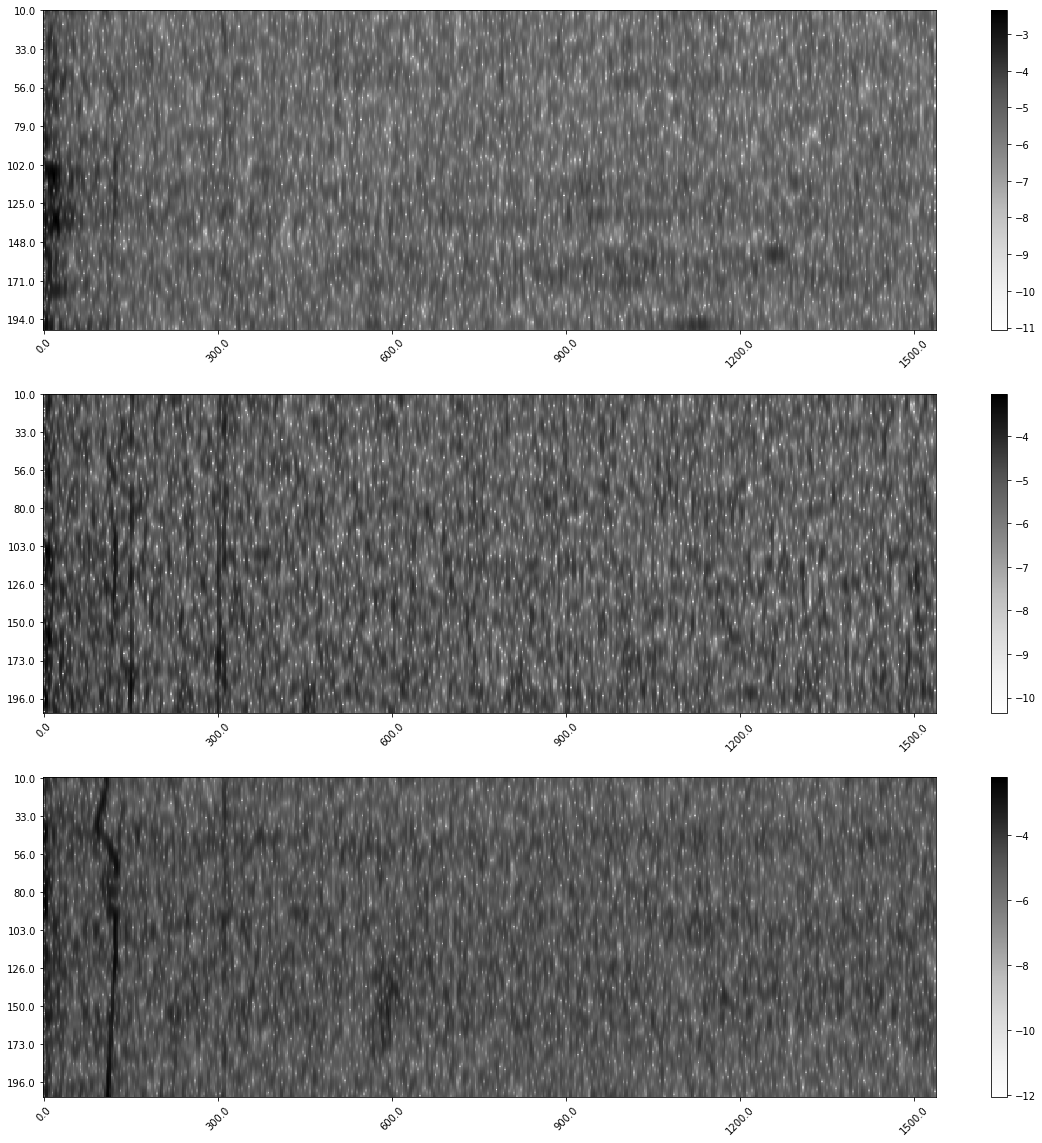

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline


fig, ax= plt.subplots(figsize=(20,20),nrows=len(data_demon_abs), ncols=1)
im = {}

for irecord in range(len(data_demon_abs)):
    im[irecord] = ax[irecord].imshow(np.log10(data_demon_abs[irecord].T),cmap="Greys",aspect='auto')
    yticks = np.floor(np.linspace(np.floor(np.min(data_time[irecord])),
                                  np.ceil(np.max(data_time[irecord])),
                                  ax[0].get_yticks().shape[0]-1))
    # first and last can be discarted
    yticks = np.append(-1,yticks)
    yticks = np.append(yticks,-1)
    ax[irecord].set_yticklabels(yticks)
    xticks = np.linspace(0,1500,ax[0].get_xticks().shape[0]-2)
    # first and last can be discarted
    xticks = np.append(-1,xticks)
    xticks = np.append(xticks,-1)
    ax[irecord].set_xticklabels(xticks,rotation=45)
    
for irecord in range(len(data_demon_abs)):
    fig.colorbar(im[irecord],ax=ax[irecord])
    

In [6]:
data_demon[0].shape

(513, 414)

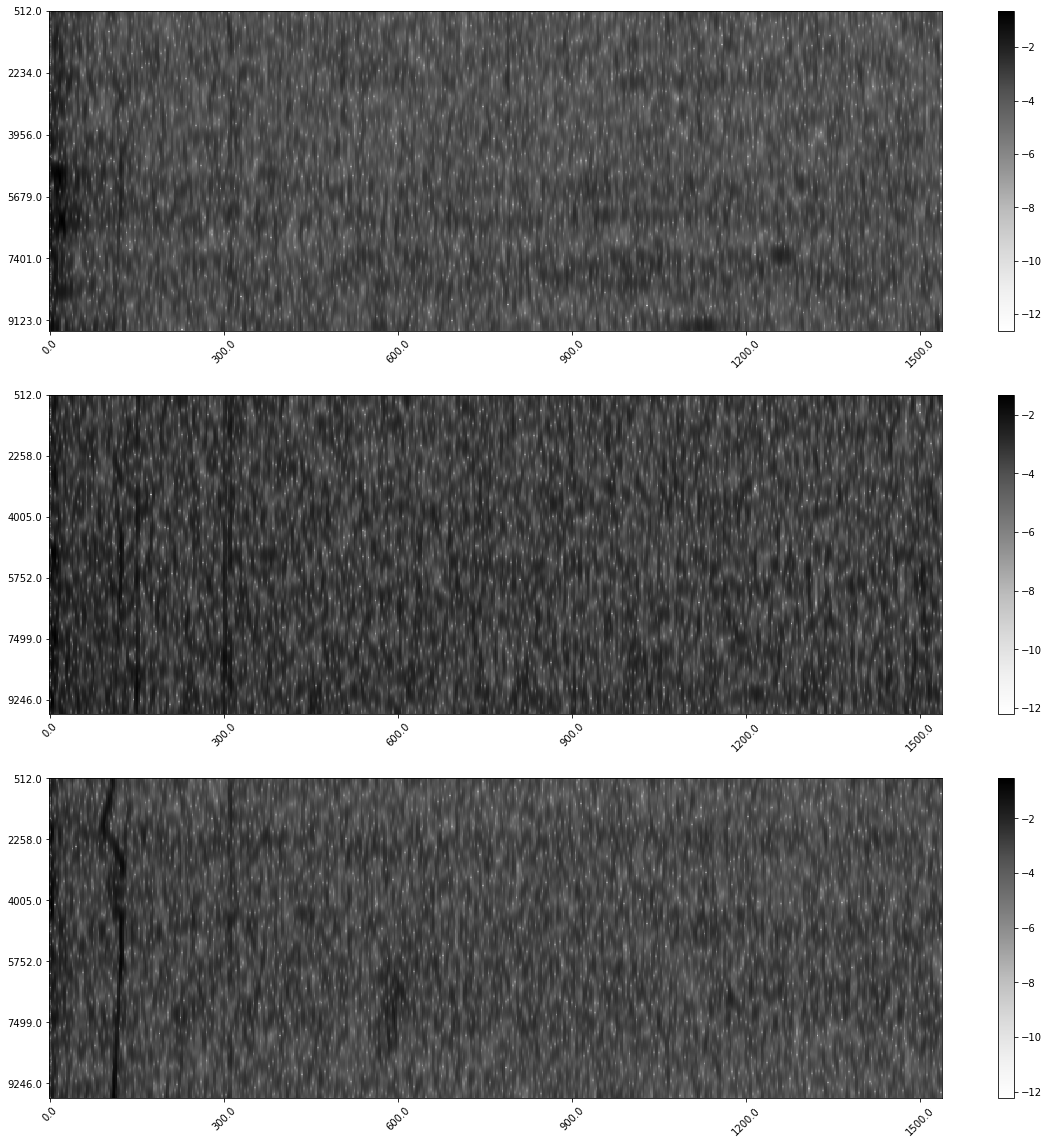

In [10]:
import Sonar

fig, ax= plt.subplots(figsize=(20,20),nrows=len(data_demon_abs), ncols=1)
im = {}

for irecord in range(len(data_demon_abs)):
    [demon_data_abs, freq, time] = Sonar.DemonAnalysis(data[irecord],fs)
    im[irecord] = ax[irecord].imshow(np.log10(demon_data_abs.T),cmap="Greys",aspect='auto')
    yticks = np.floor(np.linspace(np.floor(np.min(time)),
                                  np.ceil(np.max(time)),
                                  ax[0].get_yticks().shape[0]-1))
    # first and last can be discarted
    yticks = np.append(-1,yticks)
    yticks = np.append(yticks,-1)
    ax[irecord].set_yticklabels(yticks)
    xticks = np.linspace(0,1500,ax[0].get_xticks().shape[0]-2)
    # first and last can be discarted
    xticks = np.append(-1,xticks)
    xticks = np.append(xticks,-1)
    ax[irecord].set_xticklabels(xticks,rotation=45)
    
for irecord in range(len(data_demon_abs)):
    fig.colorbar(im[irecord],ax=ax[irecord])
    
